In [85]:
import cv2
import imutils
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
# set the folder of the puzzle
dir_folder = './map'

In [87]:
df = pd.DataFrame(columns=['img','row','col'])
for i,img in enumerate(os.listdir(dir_folder)):   
    # load image, convert to HSV
    image = cv2.imread(os.path.join(dir_folder,img))
    height, width = image.shape[:2]
    image_to_process = image.copy()
    image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2HSV) 

    colours = ['blue','red']
    counter = {}
    for colour in colours:   
        counter[colour] = 0
        if colour == 'blue':
            lower = np.array([110,200,200])
            upper = np.array([130,255,255])
        elif colour == 'red':
            lower = np.array([0,210,210])
            upper = np.array([20,255,255])

        # find the colour within the HSV range and apply the mask
        image_mask = cv2.inRange(image_to_process, lower, upper)
        image_res = cv2.bitwise_and(image_to_process, image_to_process, mask=image_mask)
        # convert to grayscale, blur it slightly and apply binary threshold
        image_gray = cv2.cvtColor(image_res, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
        _,threshold = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
        # perform edge detection, then perform dilation and erosion to close gaps between edges
        image_edged = cv2.Canny(threshold, 50, 50) 
        image_edged = cv2.dilate(image_edged, None, iterations=1)
        image_edged = cv2.erode(image_edged, None, iterations=1)
        # find contours 
        cnts = cv2.findContours(image_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # loop over the contours individually
        for c in cnts:
            # ignore if the contour is too small
            if cv2.contourArea(c) < 2:
                continue
            counter[colour] += 1
        # input dataframe with the image name, position of row and column
        df.loc[i,'img'] = img[:-4]
        if colour == 'blue':
            df.loc[i,'row'] = counter[colour]
        else:  
            df.loc[i,'col'] = counter[colour]
            
print(df)

                 img row col
0   0J0zREQH5pYYE4zW   7   2
1   0ZkBZmVynEXDg3st   9   9
2   1o10tqe59XDVqJgJ   1   1
3   2FJjkpRUXCjNzsa9   5   8
4   2N4eW2tdfRiNdCwa  10   6
..               ...  ..  ..
95  YBkrKXV2IUKjZOtd  10  10
96  YccI3iwTDme2gdct   4  10
97  yLWyuCIvqdoQveGY   8  10
98  Z9aL391gG7dIG70t   1   9
99  zvOEtwvA2ZnIiwms   6   7

[100 rows x 3 columns]


In [88]:
# sort the dataframe         
sorted_df = pd.DataFrame() 
for row in range(max(df['row'])):
    sort_df = df.loc[df['row'] == row+1]
    sort_df = sort_df.sort_values(by ='col' , ascending=True)
    sorted_df = pd.concat([sorted_df, sort_df], ignore_index=True)
print(sorted_df)

                 img row col
0   1o10tqe59XDVqJgJ   1   1
1   QPV7sTUJB1DzdLq2   1   2
2   FNSItN8siCsjmfWx   1   3
3   9yCOl10oDTFQUws7   1   4
4   KZ8MmqnXidF7ntT9   1   5
..               ...  ..  ..
95  2N4eW2tdfRiNdCwa  10   6
96  B77RTMEGjbxsPMDq  10   7
97  43ga8RlsO2A0LEAm  10   8
98  LHy4IXoXsbDlxqpZ  10   9
99  YBkrKXV2IUKjZOtd  10  10

[100 rows x 3 columns]


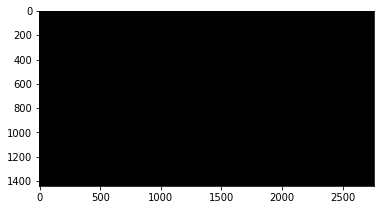

In [89]:
# make a new blank image with height and width of the final rearranged puzzle
canvas = np.zeros((height*sorted_df.loc[i,'col'],width*sorted_df.loc[i,'row'],3), np.uint8)
plt.imshow(canvas)

In [90]:
for i in range(sorted_df.shape[0]):
    patch = cv2.imread(os.path.join(dir_folder, sorted_df.loc[i,'img'] + '.jpg'))
    x, y, channels = patch.shape
    height = (sorted_df.loc[i,'col']-1)*y
    width = (sorted_df.loc[i,'row']-1)*x
    canvas[width:width+x,height:height+y]=patch
    

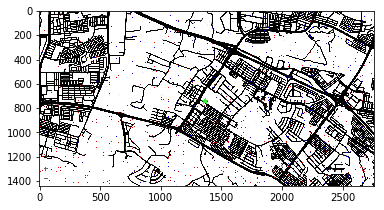

In [91]:
plt.imshow(canvas)